CNN analysis for CIFAR data.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

![title](https://pytorch.org/tutorials/_images/cifar10.png)

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./CIFAR', train=True, transform=transform, target_transform=None, download=True)
testset = torchvision.datasets.CIFAR10(root='./CIFAR', train=False, transform=transform, target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = trainset.classes

In [5]:
batch_size = 100

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, pin_memory=True)

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.conv2 = nn.Conv2d(12, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 80)  # 5*5 from image dimension
        self.fc2 = nn.Linear(80, 40)
        self.fc3 = nn.Linear(40, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def fit(net, MaxEpoch, step, trainloader, testloader, path, pathhist, device):
    net.to(device)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = torch.optim.Adagrad(net.parameters(),lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)

    hist = []
    for epoch in range(MaxEpoch + 1):  # loop over the dataset multiple times
        error = 0
        error_val = 0
        correct_train = 0
        correct_test = 0
        total_tr = 0
        total_ts = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # calculate accuracy of the predictions for the train set
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (labels == predicted).sum().item()
            total_tr += labels.size(0)

            loss.backward()
            optimizer.step()

            error += loss.item() / total_tr

        with torch.no_grad():
            for i, data in enumerate(testloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                loss_val = criterion(outputs, labels)

                # calculate accuracy of the predictions for the test set
                _, predicted = torch.max(outputs.data, 1)
                correct_test += (labels == predicted).sum().item()
                total_ts += labels.size(0)
                error_val += loss_val.item() / total_ts

            assert loss_val.requires_grad == False
        accuracy_train = correct_train / total_tr
        accuracy_test = correct_test / total_ts

        if epoch % step == 1:
            print(" epoch = ", epoch + 1,
                  f' loss = {error:.2}, accuracy for train set: {accuracy_train:.2f}, accuracy for test set: {accuracy_test:.2f}')

        temp = np.array([error, error_val, accuracy_train, accuracy_test])

        hist.append(temp)

        if epoch % 10 == 0:
            torch.save(net.state_dict(), path)
            np.save(pathhist, np.array(hist))

    torch.save(net.state_dict(), path)
    print('Finished Training and saved in ', path)
    print('History  saved in ', pathhist)
    hist = np.array(hist)
    np.save(pathhist, hist)

    return hist

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net()

In [10]:
version = "0_ADAGRAD"
path = f"./cifar_net_{version}.pt"
path_h = f"./cifar_hist_{version}.npy"

In [11]:
hist=fit(net, 100 ,10, trainloader,testloader,path, path_h ,device)

 epoch =  2  loss = 9.5, accuracy for train set: 0.50, accuracy for test set: 0.51
 epoch =  12  loss = 7.3, accuracy for train set: 0.62, accuracy for test set: 0.60
 epoch =  22  loss = 6.6, accuracy for train set: 0.65, accuracy for test set: 0.63
 epoch =  32  loss = 6.5, accuracy for train set: 0.67, accuracy for test set: 0.64
 epoch =  42  loss = 6.3, accuracy for train set: 0.68, accuracy for test set: 0.65
 epoch =  52  loss = 6.1, accuracy for train set: 0.69, accuracy for test set: 0.65
 epoch =  62  loss = 5.6, accuracy for train set: 0.70, accuracy for test set: 0.65
 epoch =  72  loss = 5.5, accuracy for train set: 0.70, accuracy for test set: 0.65
 epoch =  82  loss = 5.5, accuracy for train set: 0.71, accuracy for test set: 0.66
 epoch =  92  loss = 5.5, accuracy for train set: 0.71, accuracy for test set: 0.66
Finished Training and saved in  ./cifar_net_0_ADAGRAD.pt
History  saved in  ./cifar_hist_0_ADAGRAD.npy


In [12]:
hist_h=np.load(path_h)

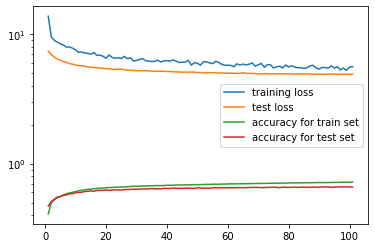

In [13]:
n=len(hist_h)
plt.plot(np.arange(n)+1,hist_h[:,0],label="training loss")
plt.plot(np.arange(n)+1,hist_h[:,1],label="test loss")
plt.plot(np.arange(n)+1,hist_h[:,2],label="accuracy for train set")
plt.plot(np.arange(n)+1,hist_h[:,3],label="accuracy for test set")
plt.legend()
plt.yscale('log')
plt.show()